In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usaidfinalsubmission/service_delivery_site_data.csv
/kaggle/input/usaid-final-submission/contraceptive_logistics_data.csv
/kaggle/input/usaid-final-submission/submission_format.csv


In [2]:
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import matplotlib.pyplot as plt
import time


from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pylab as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
train=pd.read_csv('../input/usaid-final-submission/contraceptive_logistics_data.csv')
sub = pd.read_csv('../input/usaid-final-submission/submission_format.csv')
test = pd.read_csv('../input/usaid-final-submission/submission_format.csv')
sd=pd.read_csv('../input/usaidfinalsubmission/service_delivery_site_data.csv')

In [4]:
train.columns

Index(['year', 'month', 'region', 'district', 'site_code', 'product_code',
       'stock_initial', 'stock_received', 'stock_distributed',
       'stock_adjustment', 'stock_end', 'average_monthly_consumption',
       'stock_stockout_days', 'stock_ordered'],
      dtype='object')

In [5]:
test.columns

Index(['year', 'month', 'site_code', 'product_code', 'predicted_value'], dtype='object')

In [6]:
test.head()

,year,month,site_code,product_code,predicted_value
0,2019,10,C4001,AS27134,0
1,2019,10,C4001,AS27132,0
2,2019,10,C4001,AS27000,0
3,2019,10,C4001,AS27137,0
4,2019,10,C4001,AS27138,0


In [7]:
sd.columns

Index(['site_code', 'site_type', 'site_region', 'site_district',
       'site_latitude', 'site_longitude'],
      dtype='object')

In [8]:
#drop columns in the training data that are not useful for builing the model
train.drop(columns={'stock_initial', 'stock_received','stock_adjustment', 
                    'stock_end', 'average_monthly_consumption',
                    'stock_stockout_days', 'stock_ordered'},inplace=True)

In [9]:
test.drop(['predicted_value'], axis =1, inplace = True)

In [10]:
test.head()

,year,month,site_code,product_code
0,2019,10,C4001,AS27134
1,2019,10,C4001,AS27132
2,2019,10,C4001,AS27000
3,2019,10,C4001,AS27137
4,2019,10,C4001,AS27138


In [11]:
test.dtypes

year             int64
month            int64
site_code       object
product_code    object
dtype: object

In [12]:
test=pd.merge(test,sd,on='site_code',how='left') #Merge test data with service delivery site data
test.rename(columns={'site_region':'region','site_district':'district'},inplace=True)
test=test[['year', 'month', 'region','district','site_code', 'product_code']]

In [13]:
train.head(2).append(test.head(2))

,year,month,region,district,site_code,product_code,stock_distributed
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,21.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3.0
0,2019,10,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,NaN
1,2019,10,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,NaN


In [14]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

In [15]:
#Label encode region, district, site_code and product_code so its values can be accepted by the model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in ['region','district','site_code','product_code']:
    df[col]=  df[col].astype('str')
    df[col]= le.fit_transform(df[col])

In [16]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
train.head()

,year,month,region,district,site_code,product_code,stock_distributed
0,2019,1,11,0,119,5,21.0
1,2019,1,11,0,119,3,3.0
2,2019,1,11,0,119,2,22.0
3,2019,1,11,0,119,6,0.0
4,2019,1,11,0,119,7,2.0


In [18]:
train.year.unique()

array([2019, 2018, 2017, 2016])

In [19]:
test.head()

,year,month,region,district,site_code,product_code,stock_distributed
0,2019,10,11,0,119,5,NaN
1,2019,10,11,0,119,3,NaN
2,2019,10,11,0,119,2,NaN
3,2019,10,11,0,119,6,NaN
4,2019,10,11,0,119,7,NaN


In [20]:
test.year.unique()

array([2019])

In [21]:
#convert product code in both train and test data from numerical variable to categorical variable
train['product_code'] = train['product_code'].astype('category')
test['product_code'] = test['product_code'].astype('category')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
train =pd.get_dummies(train, drop_first = True)

In [23]:
train.columns

Index(['year', 'month', 'region', 'district', 'site_code', 'stock_distributed',
       'product_code_1', 'product_code_2', 'product_code_3', 'product_code_4',
       'product_code_5', 'product_code_6', 'product_code_7', 'product_code_8',
       'product_code_9', 'product_code_10'],
      dtype='object')

In [24]:
test =pd.get_dummies(test, drop_first = True)

In [25]:
test.columns

Index(['year', 'month', 'region', 'district', 'site_code', 'stock_distributed',
       'product_code_1', 'product_code_2', 'product_code_3', 'product_code_4',
       'product_code_5', 'product_code_6', 'product_code_7', 'product_code_8',
       'product_code_9', 'product_code_10'],
      dtype='object')

In [26]:
train.columns

Index(['year', 'month', 'region', 'district', 'site_code', 'stock_distributed',
       'product_code_1', 'product_code_2', 'product_code_3', 'product_code_4',
       'product_code_5', 'product_code_6', 'product_code_7', 'product_code_8',
       'product_code_9', 'product_code_10'],
      dtype='object')

In [27]:
#both test and submission data have the same number of records after data preprocessing
len(test), len(sub)

(3115, 3115)

In [28]:
train.head()

,year,month,region,district,site_code,stock_distributed,product_code_1,product_code_2,product_code_3,product_code_4,product_code_5,product_code_6,product_code_7,product_code_8,product_code_9,product_code_10
0,2019,1,11,0,119,21.0,0,0,0,0,1,0,0,0,0,0
1,2019,1,11,0,119,3.0,0,0,1,0,0,0,0,0,0,0
2,2019,1,11,0,119,22.0,0,1,0,0,0,0,0,0,0,0
3,2019,1,11,0,119,0.0,0,0,0,0,0,1,0,0,0,0
4,2019,1,11,0,119,2.0,0,0,0,0,0,0,1,0,0,0


In [29]:
test.head()

,year,month,region,district,site_code,stock_distributed,product_code_1,product_code_2,product_code_3,product_code_4,product_code_5,product_code_6,product_code_7,product_code_8,product_code_9,product_code_10
0,2019,10,11,0,119,NaN,0,0,0,0,1,0,0,0,0,0
1,2019,10,11,0,119,NaN,0,0,1,0,0,0,0,0,0,0
2,2019,10,11,0,119,NaN,0,1,0,0,0,0,0,0,0,0
3,2019,10,11,0,119,NaN,0,0,0,0,0,1,0,0,0,0
4,2019,10,11,0,119,NaN,0,0,0,0,0,0,1,0,0,0


In [30]:
train.corr()

,year,month,region,district,site_code,stock_distributed,product_code_1,product_code_2,product_code_3,product_code_4,product_code_5,product_code_6,product_code_7,product_code_8,product_code_9,product_code_10
year,1.000000,-0.191016,-0.028990,-0.016426,-0.015245,0.009055,0.156266,-0.007252,-0.011982,-0.013596,-0.027153,0.006429,0.044771,-0.018397,-0.003149,-0.017107
month,-0.191016,1.000000,-0.001431,0.001167,0.002958,0.004145,-0.009155,0.002897,0.000583,-0.002013,0.000126,0.000730,0.000397,-0.002231,0.013983,-0.002652
region,-0.028990,-0.001431,1.000000,-0.009061,0.520614,-0.030530,-0.037977,0.005724,-0.013614,0.022181,-0.018690,0.015869,-0.004848,0.049511,-0.007973,-0.016273
district,-0.016426,0.001167,-0.009061,1.000000,0.094775,-0.025625,-0.004275,-0.020570,0.004507,-0.029640,-0.018258,-0.001128,0.007058,0.048489,0.028481,-0.010105
site_code,-0.015245,0.002958,0.520614,0.094775,1.000000,-0.062439,-0.033595,0.014692,-0.011797,0.035514,-0.013000,0.011098,0.012047,0.019765,-0.021152,-0.024723
stock_distributed,0.009055,0.004145,-0.030530,-0.025625,-0.062439,1.000000,-0.037728,0.158383,-0.088686,0.141248,0.052328,-0.076418,-0.071193,-0.090831,-0.075334,0.027305
product_code_1,0.156266,-0.009155,-0.037977,-0.004275,-0.033595,-0.037728,1.000000,-0.049957,-0.045124,-0.050540,-0.046570,-0.045441,-0.043440,-0.031619,-0.025287,-0.029015
product_code_2,-0.007252,0.002897,0.005724,-0.020570,0.014692,0.158383,-0.049957,1.000000,-0.155510,-0.174176,-0.160493,-0.156601,-0.149707,-0.108967,-0.087146,-0.099994
product_code_3,-0.011982,0.000583,-0.013614,0.004507,-0.011797,-0.088686,-0.045124,-0.155510,1.000000,-0.157327,-0.144968,-0.141452,-0.135225,-0.098426,-0.078716,-0.090321
product_code_4,-0.013596,-0.002013,0.022181,-0.029640,0.035514,0.141248,-0.050540,-0.174176,-0.157327,1.000000,-0.162368,-0.158431,-0.151456,-0.110240,-0.088164,-0.101162


In [31]:
#a further dropping of variables that are not useful to the model due to multicollinearity effect
train.drop(columns = ['month', 'district', 'region', 'product_code_6', 'product_code_3', 'product_code_7', 'product_code_9'], axis = 1, inplace = True)
test.drop(columns = ['month', 'district', 'region', 'product_code_6', 'product_code_3', 'product_code_7', 'product_code_9'], axis = 1, inplace = True)

(9.5, -0.5)

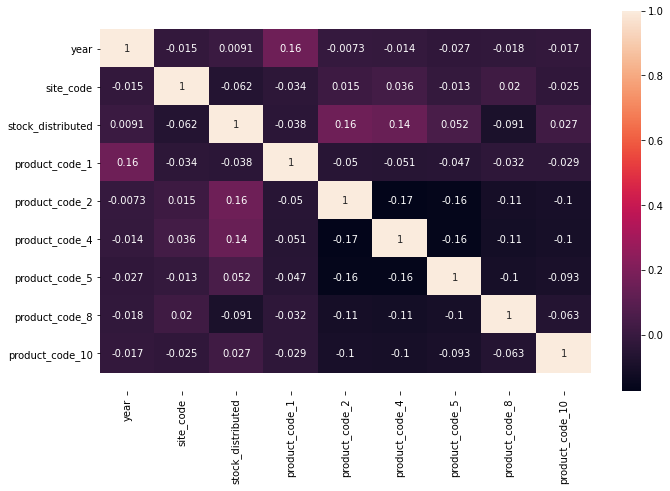

In [32]:
corr = train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot = True, ax = ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [33]:
#this code takes care of invalid zeros in cases where stock_distributed for a contraceptive product at a service delivery site is reported in a given month as '0'
train['stock_distributed'] = np.where(train['stock_distributed'] == 0, train['stock_distributed'].median(), 
                                      train['stock_distributed'])

In [34]:
X=train.drop(columns={'stock_distributed'})
y=train.loc[:,['stock_distributed']]
del test['stock_distributed']


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=100)

In [35]:
#Define the model 
my_model = XGBRegressor()

In [36]:
##Hyper Parameter Optimization 
n_estimators = [100, 500, 900, 1100, 1500] 
max_depth = [2, 3, 5, 10, 15] 
booster = ['gbtree', 'gblinear']
learning_rate = [0.05, 0.1, 0.15, 0.20] 
min_child_weight = [1, 2, 3, 4]
base_score = [0.25, 0.5, 0.75, 1]

In [37]:
#Define the grid of hyperparameters to search 
hyperparameter_grid = { 'n_estimators' : n_estimators, 'max_depth': max_depth,
'learning_rate': learning_rate, 'min_child_weight': min_child_weight, 'booster': booster, 'base_score': base_score }

In [38]:
#Set up the random search with 4-fold cross validation 
random_cv = RandomizedSearchCV(estimator=my_model, param_distributions = hyperparameter_grid, cv = 5, n_iter = 50, 
                               scoring = 'neg_mean_absolute_error', n_jobs = 4, verbose = 5, return_train_score = True,random_state = 42)

In [39]:
#fit the model 
random_cv.fit(train_X, train_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   28.5s
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 12.7min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=50, n_jobs=4,
                   para

In [40]:
#The optimal random search paramaters
random_cv.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
my_model = XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
my_model.fit(train_X, train_y) 

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
#prediction on the validation set
valid_pred = my_model.predict(valid_X)

In [44]:
#RMSE score from fitting the model to the validation set
rmse = sqrt(mean_squared_error(valid_y, valid_pred))

print(rmse)

33.38380018154267


In [45]:
#Predict stock_distributed from OCT 2019 - DEC 2019
pred = my_model.predict(test)

In [46]:
sub['predicted_value']=np.abs(pred)

In [47]:
#Convert the predcited value to the nearest whole number
sub['predicted_value'] = sub['predicted_value'].round()

In [48]:
sub.to_csv('Fork of Second_Model.csv', index=False)